<a href="https://colab.research.google.com/github/mhsh77/EMA-BB-Martingale-Optimization/blob/main/Ema_bb_optimization_martingale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
%pip install pandas_ta
!pip install backtesting
import pandas_ta as ta
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from backtesting import Strategy,Backtest
from tqdm import tqdm
import seaborn as sb
import matplotlib.pyplot as plt

In [85]:
df = pd.read_csv('/content/drive/MyDrive/trading/EURUSD_Candlestick_4_Hour_BID_01.12.2020-14.12.2024.csv')
indexZero = df[ df['Volume']==0 ].index #get the index of times that the volume is zero(weekends)
df.drop(indexZero,inplace=True)
df = df[df['Volume']!=0]
df.reset_index(drop=True,inplace=True)
df.isna().sum() #checking for missing data
df.rename(columns={'Local time':'Time'},inplace=True)
df.set_index('Time')
df.head()

,Time,Open,High,Low,Close,Volume
0,30.11.2020 21:30:00.000 GMT+0330,1.19543,1.19597,1.19236,1.19256,37098.1192
1,01.12.2020 01:30:00.000 GMT+0330,1.19260,1.19494,1.19249,1.19492,25860.5809
2,01.12.2020 05:30:00.000 GMT+0330,1.19493,1.19598,1.19479,1.19569,34066.8594
3,01.12.2020 09:30:00.000 GMT+0330,1.19571,1.19855,1.19539,1.19806,70234.9814
4,01.12.2020 13:30:00.000 GMT+0330,1.19805,1.19938,1.19601,1.19921,68285.1796


In [86]:
df["EMA30"] = ta.ema(df.Close,30)
df["RSI"] = ta.ema(df.Close,10)
bbbands = ta.bbands(df.Close,15,1.5)
df["ATR"] = ta.atr(df.High,df.Low,df.Close,7)
df=df.join([bbbands])
df["EMA7"] = ta.ema(df.Close,7)
df.tail()
df.rename(columns={'BBL_15_1.5':'bbl','BBU_15_1.5':'bbu'},inplace=True)
df

,Time,Open,High,Low,Close,Volume,EMA30,RSI,ATR,bbl,BBM_15_1.5,bbu,BBB_15_1.5,BBP_15_1.5,EMA7
0,30.11.2020 21:30:00.000 GMT+0330,1.19543,1.19597,1.19236,1.19256,37098.1192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01.12.2020 01:30:00.000 GMT+0330,1.19260,1.19494,1.19249,1.19492,25860.5809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01.12.2020 05:30:00.000 GMT+0330,1.19493,1.19598,1.19479,1.19569,34066.8594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01.12.2020 09:30:00.000 GMT+0330,1.19571,1.19855,1.19539,1.19806,70234.9814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01.12.2020 13:30:00.000 GMT+0330,1.19805,1.19938,1.19601,1.19921,68285.1796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6302,13.12.2024 05:30:00.000 GMT+0330,1.04652,1.04667,1.04562,1.04652,11893.9500,1.051276,1.048766,0.002824,1.046670,1.049967,1.053263,0.627893,-0.022803,1.048089
6303,13.12.2024 09:30:00.000 GMT+0330,1.04653,1.04940,1.04531,1.04871,26114.9200,1.051111,1.048756,0.003005,1.046565,1.049702,1.052839,0.597693,0.341887,1.048244
6304,13.12.2024 13:30:00.000 GMT+0330,1.04873,1.05241,1.04834,1.05102,52522.7400,1.051105,1.049167,0.003157,1.046724,1.049539,1.052354,0.536398,0.763009,1.048938
6305,13.12.2024 17:30:00.000 GMT+0330,1.05102,1.05103,1.04822,1.04963,47795.5400,1.051010,1.049252,0.003107,1.046781,1.049355,1.051930,0.490736,0.553338,1.049111


In [87]:
tqdm.pandas()

def signalgen(df, current):
    if df['EMA7'][current] > df['EMA30'][current] and df.Close[current]<df.bbl[current]:#upward and lower than lower bb
        return 1
    elif df['EMA7'][current] < df['EMA30'][current] and df.Close[current]>df.bbu[current]:
        return 2
    else:
      return 0

df["Signal"] = df.progress_apply(lambda row: signalgen(df, row.name), axis=1)

df.tail()


100%|██████████| 6307/6307 [00:01<00:00, 4908.31it/s]


,Time,Open,High,Low,Close,Volume,EMA30,RSI,ATR,bbl,BBM_15_1.5,bbu,BBB_15_1.5,BBP_15_1.5,EMA7,Signal
6302,13.12.2024 05:30:00.000 GMT+0330,1.04652,1.04667,1.04562,1.04652,11893.95,1.051276,1.048766,0.002824,1.046670,1.049967,1.053263,0.627893,-0.022803,1.048089,0
6303,13.12.2024 09:30:00.000 GMT+0330,1.04653,1.04940,1.04531,1.04871,26114.92,1.051111,1.048756,0.003005,1.046565,1.049702,1.052839,0.597693,0.341887,1.048244,0
6304,13.12.2024 13:30:00.000 GMT+0330,1.04873,1.05241,1.04834,1.05102,52522.74,1.051105,1.049167,0.003157,1.046724,1.049539,1.052354,0.536398,0.763009,1.048938,0
6305,13.12.2024 17:30:00.000 GMT+0330,1.05102,1.05103,1.04822,1.04963,47795.54,1.051010,1.049252,0.003107,1.046781,1.049355,1.051930,0.490736,0.553338,1.049111,0
6306,13.12.2024 21:30:00.000 GMT+0330,1.04964,1.05045,1.04891,1.05017,24674.05,1.050956,1.049419,0.002883,1.046783,1.049363,1.051943,0.491732,0.656329,1.049376,0


In [146]:
class BuySellStrategy(Strategy):
    stop=3
    profit=6

    def init(self):

        self.signal = self.I(lambda: self.data.Signal)
        self.ema30 =  self.I(lambda:self.data.EMA30,name='EMA30')
        self.ema7 = self.I(lambda:self.data.EMA7,name='EMA7')
        self.upp = self.I(lambda:self.data.bbu,name='upperbb')
        self.upp = self.I(lambda:self.data.bbl,name='lowerbb')
        self.initval = 10
        self.ordersize = self.initval
    def next(self):
        if self.data.Signal[-1] ==1 and len(self.trades)==0:  # Buy signal and no open position
            sl = self.data.Close[-1] - self.stop*self.data.ATR
            tp = self.data.Close[-1] + self.profit*self.data.ATR
            self.buy(sl=sl,tp=tp,size=self.ordersize)
            #print(f"Buy executed at {self.data.Close[-1]}")
        elif self.data.Signal[-1] == 2 and len(self.trades)==0:  # Sell signal and an open position
            sl = self.data.Close[-1] + self.stop*self.data.ATR
            tp = self.data.Close[-1] - self.profit*self.data.ATR
            self.sell(sl=sl,tp=tp,size=self.ordersize)
            #print(f"Sell executed at {self.data.Close[-1]}")


# Backtest the strategy
bt = Backtest(df, BuySellStrategy, cash=100,margin=1, commission=0.00)
result = bt.run()
print(result)
bt.plot()

<ipython-input-146-35c230134a43>:28: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, BuySellStrategy, cash=100,margin=1, commission=0.00)


Start                                     0.0
End                                    6306.0
Duration                               6306.0
Exposure Time [%]                   63.722848
Equity Final [$]                   100.361935
Equity Peak [$]                    100.929607
Return [%]                           0.361935
Buy & Hold Return [%]               -11.93986
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -1.685007
Avg. Drawdown [%]                   -0.127168
Max. Drawdown Duration                 2534.0
Avg. Drawdown Duration             161.078947
# Trades                                 79.0
Win Rate [%]                        35.443038
Best Trade [%]                       3.075924
Worst Trade [%]                     -1.968834
Avg. Trade [%]                    

GridPlot(id='p16986', ...)

In [144]:
class BuySellStrategy(Strategy):
    stop=3.1
    profit=3.1

    def init(self):

        self.signal = self.I(lambda: self.data.Signal)
        self.ema30 =  self.I(lambda:self.data.EMA30,name='EMA30')
        self.ema7 = self.I(lambda:self.data.EMA7,name='EMA7')
        self.upp = self.I(lambda:self.data.bbu,name='upperbb')
        self.upp = self.I(lambda:self.data.bbl,name='lowerbb')
        self.initval = 10
        self.ordersize = self.initval
    def next(self):
        if(self.signal>0 and len(self.trades)==0 and len(self.closed_trades)>0 and self.closed_trades[-1].pl<0):
          self.ordersize*=2
          #if the signal
        elif len(self.closed_trades)>0 and self.closed_trades[-1].pl>0:
          self.ordersize = self.initval
        if self.data.Signal[-1] ==1 and len(self.trades)==0:  # Buy signal and no open position
            sl = self.data.Close[-1] - self.stop*self.data.ATR
            tp = self.data.Close[-1] + self.profit*self.data.ATR
            self.buy(sl=sl,tp=tp,size=self.ordersize)
            #print(f"Buy executed at {self.data.Close[-1]}")
        elif self.data.Signal[-1] == 2 and len(self.trades)==0:  # Sell signal and an open position
            sl = self.data.Close[-1] + self.stop*self.data.ATR
            tp = self.data.Close[-1] - self.profit*self.data.ATR
            self.sell(sl=sl,tp=tp,size=self.ordersize)
            #print(f"Sell executed at {self.data.Close[-1]}")


# Backtest the strategy
bt = Backtest(df, BuySellStrategy, cash=100,margin=1, commission=0.00)
result = bt.run()
print(result)

<ipython-input-144-814f7b7ed4c3>:33: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, BuySellStrategy, cash=100,margin=1, commission=0.00)


Start                                     0.0
End                                    6306.0
Duration                               6306.0
Exposure Time [%]                   21.547487
Equity Final [$]                   100.084908
Equity Peak [$]                    102.721318
Return [%]                           0.084908
Buy & Hold Return [%]               -11.93986
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -2.566566
Avg. Drawdown [%]                   -0.122405
Max. Drawdown Duration                 3538.0
Avg. Drawdown Duration              66.493827
# Trades                                 53.0
Win Rate [%]                        54.716981
Best Trade [%]                       1.770805
Worst Trade [%]                      -2.01962
Avg. Trade [%]                    

/usr/local/lib/python3.10/dist-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 400 configurations.
  output = _optimize_grid()


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Start                                     0.0
End                                    6306.0
Duration                               6306.0
Exposure Time [%]                    49.69082
Equity Final [$]                   106.761696
Equity Peak [$]                    106.792996
Return [%]                           6.761696
Buy & Hold Return [%]               -11.93986
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                     -2.5526
Avg. Drawdown [%]                   -0.095498
Max. Drawdown Duration                  261.0
Avg. Drawdown Duration              22.076923
# Trades                                110.0
Win Rate [%]                        58.181818
Best Trade [%]                       2.056577
Worst Trade [%]                     -2.345365
Avg. Trade [%]                    

<Axes: xlabel='profit', ylabel='stop'>

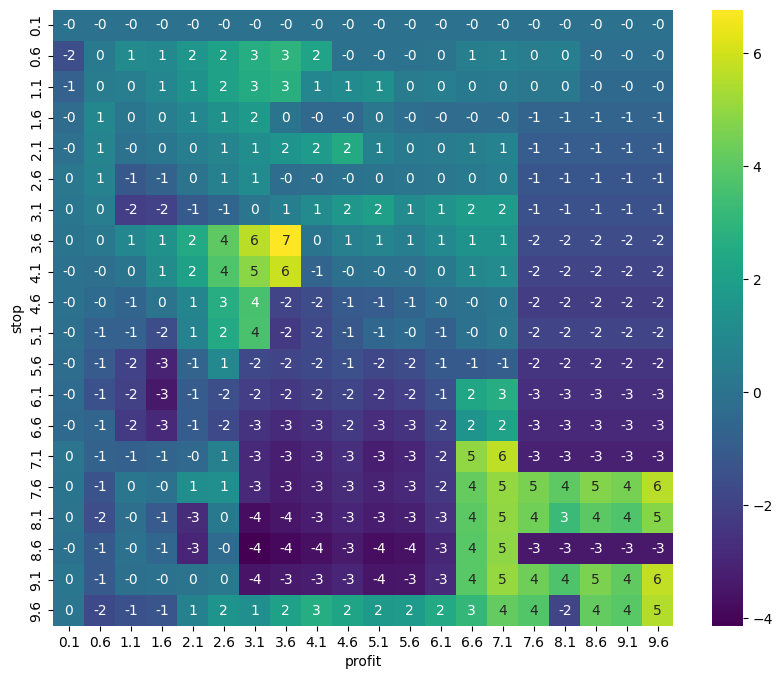

In [141]:
stats,heatmap = bt.optimize(stop=[i/10 for i in range(1,100,5)],profit=[i/10 for i in range(1,100,5)],maximize='Return [%]',
                            random_state=0,return_heatmap=True)
print(stats)

heatmap_df = heatmap.unstack()
plt.figure(figsize=(10,8))
sb.heatmap(heatmap_df,annot=True,cmap='viridis',fmt='.0f')

In [142]:
bt.plot()

GridPlot(id='p16166', ...)

In [143]:
stats["_strategy"]

<Strategy BuySellStrategy(stop=3.6,profit=3.6)>